# **CVPS20 // Linear Regression and Template fitting**

*September 29, 2020*

In this notebook, we explore several different ways of performing linear regression on 1D and 2D data.

---

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as iio
from scipy.ndimage.filters import gaussian_filter as gf

<ipython-input-1-f38629e1fc13>:4: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter as gf


In [2]:
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gist_gray"

### Regression the Normal Equation

#### **Linear Regression**

Here are two data sets:


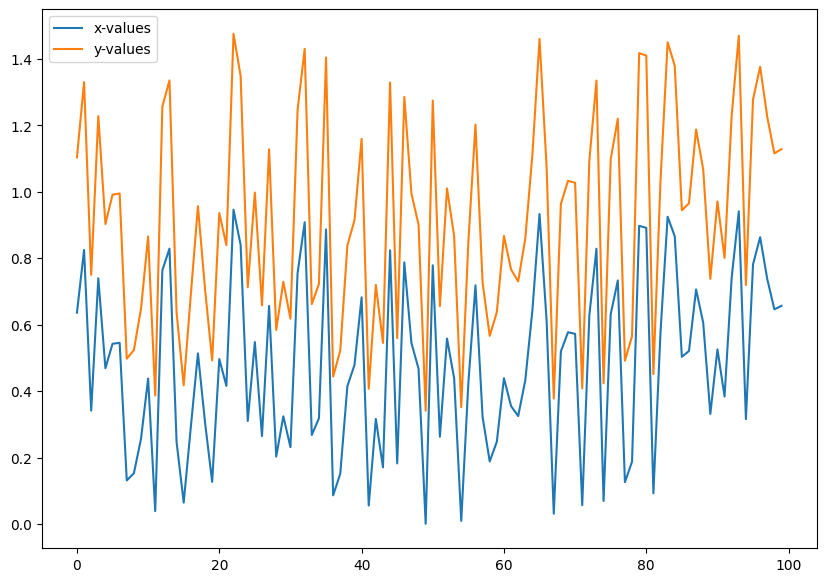

In [8]:
# -- create some data
np.random.seed(302)
a0 = 0.34
a1 = 1.2
x = np.random.rand(100)
y = a0 + a1 * x

# -- plot it
fig, ax = plt.subplots()
ax.plot(x, label="x-values")
ax.plot(y, label="y-values")
ax.legend(loc="upper left")
fig.show()

Let's use `numpy`'s `polyfit()` (with a model of order 1) to recover the input coefficients:

In [4]:
# -- use the data to solve for the best fit coefficients
co = np.polyfit(x, y, 1)

print("a0 = {0}".format(co[1]))
print("a1 = {0}".format(co[0]))

a0 = 0.3399999999999998
a1 = 1.2000000000000002


***How did `numpy` determine the value of these paramters?***

Our task with linear regression is to determine the parameters $a_0$ and $a_1$ from the data alone.  We are trying to solve the equation,

$ y = a_0 + a_1 \ x$

but even though this looks like one equation, it is actually 100,

$y_0 = a_0 + a_1 \ x_0$ \\
$y_1 = a_0 + a_1 \ x_1$ \\
$y_2 = a_0 + a_1 \ x_2$ \\
$y_3 = a_0 + a_1 \ x_3$ \\
. \\
. \\
. \\
$y_{99} = a_0 + a_1 \ x_{99}$ \\




Note, this can be rewritten as


$\left(\begin{array}{c}
y_{0} \\
y_{1} \\
y_{2} \\
y_{3} \\
. \\
. \\
. \\
y_{99}
\end{array}\right)
=
\left(\begin{array}{cc}
1 & x_{0} \\
1 & x_{1} \\
1 & x_{2} \\
1 & x_{3} \\
. \\
. \\
. \\
1 & x_{99}
\end{array}\right)
\
\left(\begin{array}{c}
a_0 \\
a_1
\end{array}\right)$

or

$\vec{y} = {\bf P} \ \vec{a}$

Where $\vec{y}$ is a vector, ${\bf P}$ is a matrix, and $\vec{a}$ is a vector of coefficients (in our case amplitude and offset).  Equations that look the one above are referred to as the **Normal Equation**.

Matrix equations like this cannot be solved (i.e., for $\vec{a}$) simply by dividing through by ${\bf P}$ since ${\bf P}$ is a matrix.  Nor can we multiply both sides by the inverse of ${\bf P}$ since it is not a square matrix (for a review of matrix multiplication and inversion see [here](https://en.wikipedia.org/wiki/Matrix_multiplication) and [here](https://en.wikipedia.org/wiki/Invertible_matrix#Analytic_solution)).

But ${\bf P}^T {\bf P}$ *is* square, and so the solution to the Normal Equation is,

$\vec{y} = {\bf P} \ \vec{a}$

${\bf P}^{T} \vec{y} = {\bf P}^T {\bf P} \ \vec{a}$

$({\bf P}^T {\bf P})^{-1} \cdot {\bf P}^{T} \vec{y} = \vec{a}$

We can use `numpy`'s linear algebra libraries to implement the solution,

In [14]:
# -- solve the normal equation with linear algebra functions
PT = np.array([np.ones_like(x), x])
P = PT.T

PTy = np.dot(PT, y)
PTP = np.dot(PT, P)
PTPi = np.linalg.inv(PTP)

avec = np.dot(PTPi, PTy)

print("a0 = {0}".format(avec[0]))
print("a1 = {0}".format(avec[1]))

a0 = 0.3399999999999994
a1 = 1.2000000000000006


It turns out that the solution to the normal equation is equivalent to the classic "least squares minimization" solution.


#### **Multi-variate Regression**

Let's try a slightly more complex example.

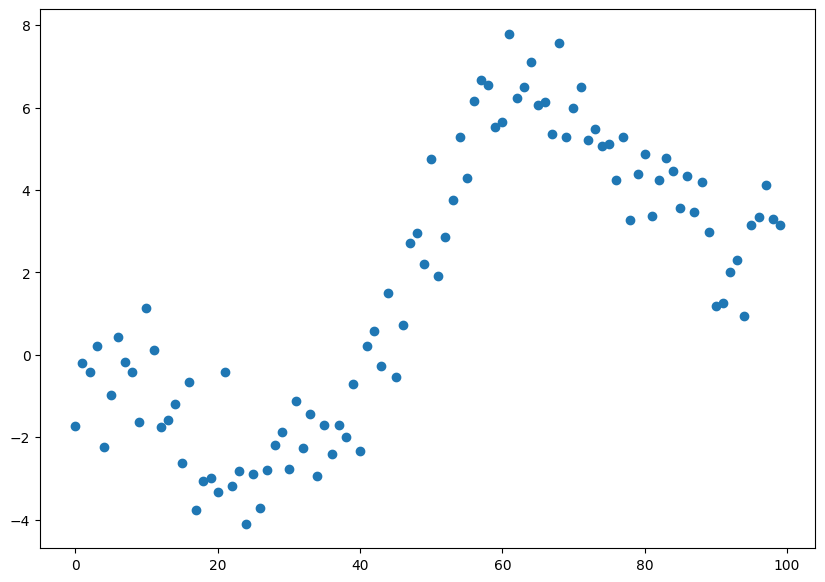

In [26]:
# -- generate 3 1D data sets
xval = np.linspace(0, 10, 100, False)

x1 = np.exp(-xval**2 / (2.0 * 4.0**2))
x2 = np.cos(xval)
x3 = np.sqrt(xval / 20.)

np.random.seed(712)
noise = np.random.randn(len(xval))

y = 1 + -5 * x1 + 3 * x2 + 7 * x3 + 1 * noise

fig, ax = plt.subplots()
ax.plot(y, 'o')
fig.show()

Now create the "template" matrix and fit,

In [27]:
# -- create template matrix and fit
P = np.array([np.ones_like(xval), x1, x2, x3]).T
PTy = np.dot(P.T, y)
PTP = np.dot(P.T, P)
PTPi = np.linalg.inv(PTP)

avec = np.dot(PTPi, PTy)

print("avec = {0}".format(avec))

avec = [ 0.26988975 -4.55026359  2.87472805  8.08907678]


MSE : 0.8217006818355571


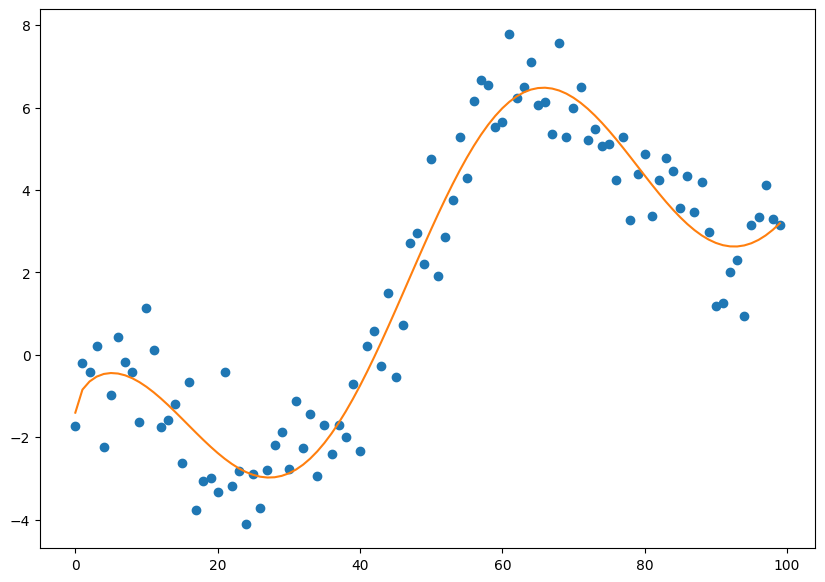

In [28]:
# -- create the model
model = avec[0] + avec[1] * x1 + avec[2] * x2 + avec[3] * x3
mse = np.mean((y - model)**2)
print("MSE : {0}".format(mse))

# -- plot it
fig, ax = plt.subplots()
ax.plot(y, "o")
ax.plot(model)
fig.show()

The fit does reasonably well, but what happens if we try the **completely** wrong model?

avec = [ 1.85743941 -6.30080027  2.43536793 -0.27224583  0.00908676]
MSE : 1.9180287477665283


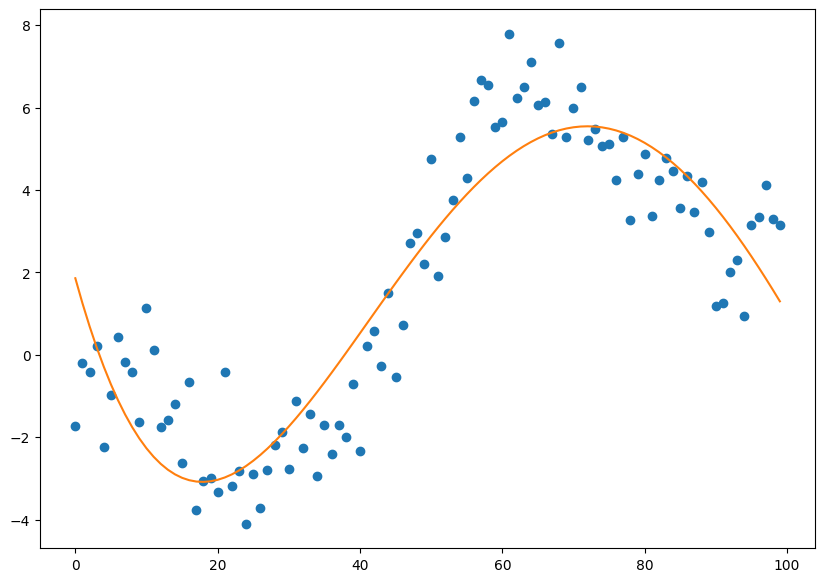

In [29]:
# -- create a template matrix with very incorrect generating functions
P = np.array([np.ones_like(xval), xval, xval**2, xval**3, xval**4]).T
PTy = np.dot(P.T, y)
PTP = np.dot(P.T, P)
PTPi = np.linalg.inv(PTP)
avec = np.dot(PTPi, PTy)

print("avec = {0}".format(avec))

# -- create the model
model = avec[0] + avec[1] * xval + avec[2] * xval**2 + avec[3] * xval**3 + avec[4] * xval**4
mse = np.mean((y - model)**2)
print("MSE : {0}".format(mse))

# -- plot it
fig, ax = plt.subplots()
ax.plot(y, "o")
ax.plot(model)
fig.show()

Pretty good for the *completely* wrong model!  So regressions (and template models in general) can be powerful, but in order to evaluate a fit, you really have to know something about your errors and be **very careful** about interpretting correlations with templates.



---

### Correlation and Templates fitting with Images

#### **Example: Hand-written Digits (part 1)**

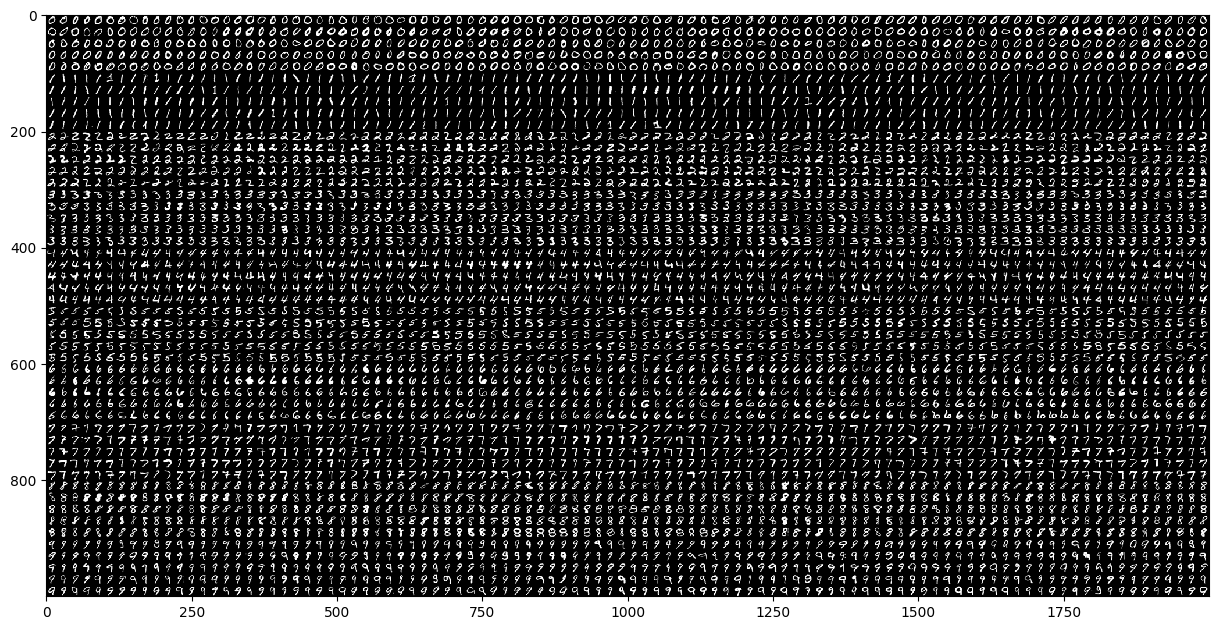

In [32]:
# -- load in the hand-written digits data set
fname = "/content/drive/My Drive/cvps20/data/examples/digits.png"
digits = np.asarray(iio.v2.imread(fname)) / 255.

# -- plot it
fig, ax = plt.subplots(figsize=(15, 8))
ax.imshow(digits)
fig.show()

Let's use a bit of reshaping and transposing magic to isolate the individual digit images:

In [33]:
digits.shape

(1000, 2000)

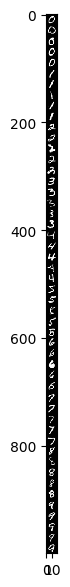

In [50]:
plt.imshow(digits.reshape(1000, 100, 20).transpose(1, 0, 2)[0])

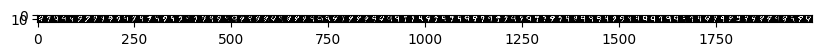

In [58]:
plt.imshow(digits.reshape(50, 20, 2000)[-1])

In [59]:
# -- get a list of individual numbers (note they are 20x20 pixels)
nums = digits.reshape(50, 20, 100, 20).transpose(0, 2, 1, 3).reshape(5000, 20, 20)

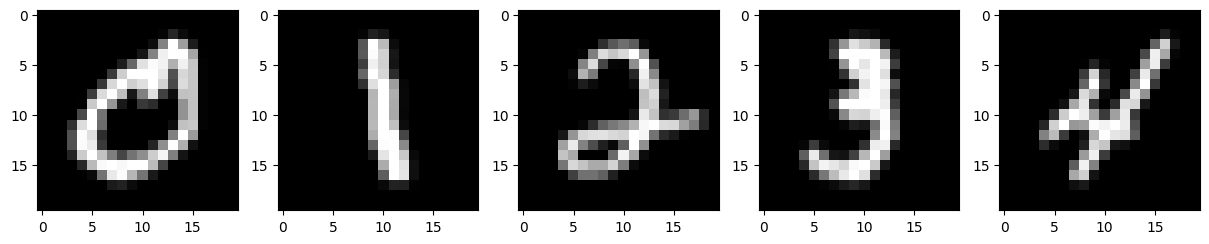

In [64]:
# -- show some examples
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for ii in range(5):
  ax[ii].imshow(nums[ii*500 + 1])
fig.show()



Let's try to guess what a given image is by building a linear model that regresses templates for each digit against that image.

In [65]:
# -- build templates by taking the mean across all examples
templs = np.zeros((10, 20, 20))

for ii in range(10):
  templs[ii] = np.mean(nums[ii * 500 : (ii + 1) * 500], axis=0)

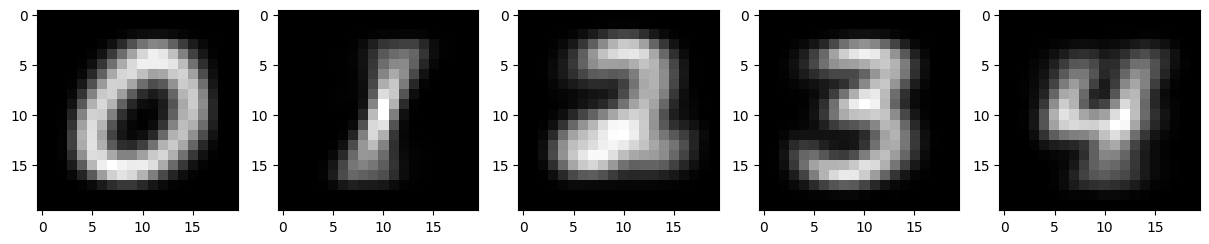

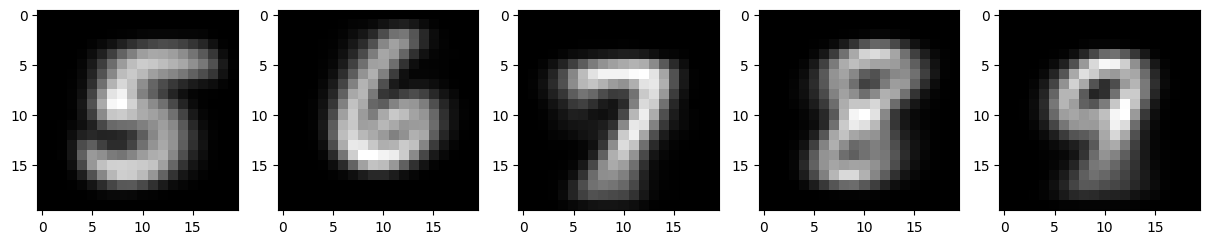

In [66]:
# -- show the templates
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for ii in range(5):
  ax[ii].imshow(templs[ii])
fig.show()

fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for ii in range(5, 10):
  ax[ii-5].imshow(templs[ii])

fig.show()

Now pick a random image:

In [109]:
# -- select random image index
# np.random.seed(302)
ind = np.random.randint(0, nums.shape[0])
img = nums[ind]

We can solve the normal equation by flattening the 2D images

avec = [-0.19825108  0.08910238  0.60917274  0.03729705  0.19544585  0.42508279
  0.23328743 -0.31107154 -0.27865555  0.15188821]



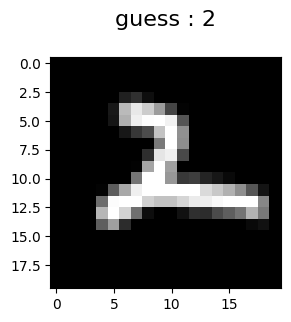

In [110]:
# -- what is the guess?
P = np.array([templs[0].flatten(), templs[1].flatten(), templs[2].flatten(),
              templs[3].flatten(), templs[4].flatten(), templs[5].flatten(),
              templs[6].flatten(), templs[7].flatten(), templs[8].flatten(),
              templs[9].flatten()]).T

PTy = np.dot(P.T, img.flatten())
PTP = np.dot(P.T, P)
PTPi = np.linalg.inv(PTP)

avec = np.dot(PTPi, PTy)

print("avec = {0}\n".format(avec))

# -- the guess is the index of the maximum avec
guess = avec.argmax()

# -- show it
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(img)
ax.set_title("guess : {0}\n".format(guess), fontsize=16)
fig.show()

*Note: this is only the **most basic** technique of recognizing handwritten characters. There are much more effective ways to solve this problem that we'll cover in a couple of weeks, but it is a good illustration of regressions and correlations...*

# Evaluate the Results

In [117]:
X = nums.reshape(5000, 400).T
y = np.arange(10).repeat(500)

In [119]:
PTy = np.dot(P.T, X)
PTP = np.dot(P.T, P)
PTPi = np.linalg.inv(PTP)

avecs = np.dot(PTPi, PTy)

In [122]:
predict = avecs.argmax(axis=0)

In [125]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [124]:
confusion_matrix(y, predict)

array([[357,   0,   0,   7,   8,  66,  27,   3,  20,  12],
       [  0, 468,   1,   1,   1,  10,   8,   0,   8,   3],
       [  0,  23, 327,  32,  21,   8,  15,  23,  30,  21],
       [  1,   7,  21, 366,   2,  22,   8,   9,  29,  35],
       [  0,  14,   8,   6, 381,  18,  12,   2,   4,  55],
       [  5,   3,   1,  92,  15, 308,  13,   0,  22,  41],
       [  3,  11,   2,   0,  30,  39, 407,   3,   2,   3],
       [  3,  19,  10,   2,  24,   5,   1, 376,   2,  58],
       [  1,  19,   5,  44,  11,  25,   7,   2, 351,  35],
       [  7,   8,   4,  13,  24,  20,   0,  11,  11, 402]])

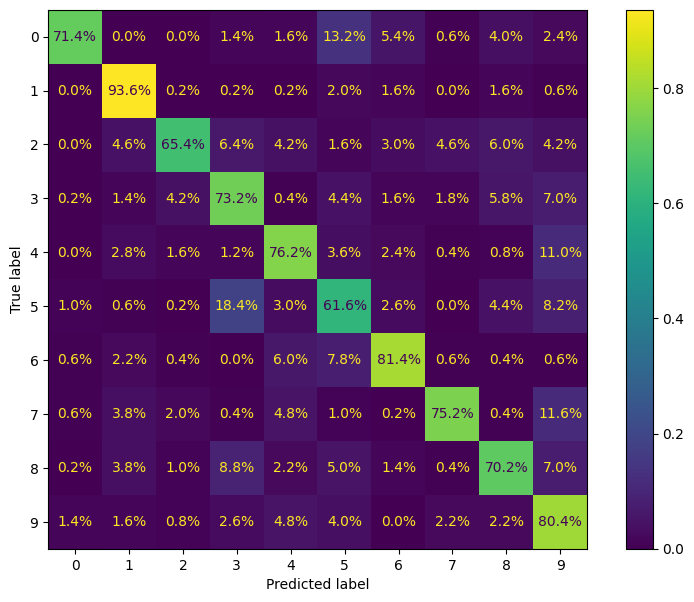

In [130]:
ConfusionMatrixDisplay.from_predictions(y, predict,
                                        normalize='true', values_format='.1%'
                                        )

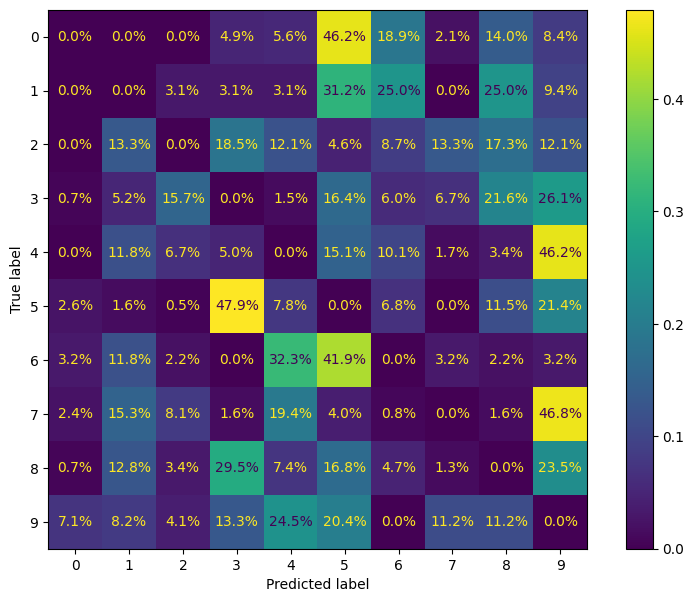

In [131]:
sample_weight = (predict != y)
ConfusionMatrixDisplay.from_predictions(y, predict,
                                        sample_weight=sample_weight,
                                        normalize='true', values_format='.1%'
                                        )

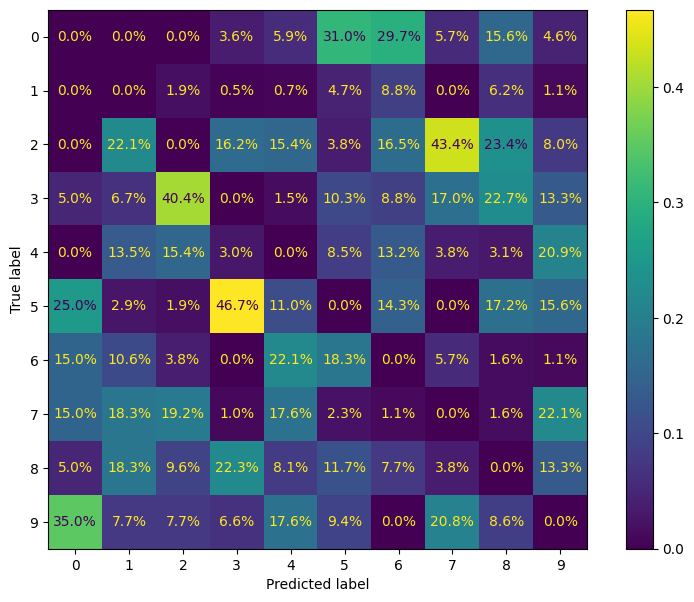

In [132]:
ConfusionMatrixDisplay.from_predictions(y, predict,
                                        sample_weight=sample_weight,
                                        normalize='pred', values_format='.1%'
                                        )